In [1]:
# -*- coding: utf-8 -*-

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from html_table_parser import parser_functions as parse
from time import sleep
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import math
% matplotlib inline

In [3]:
import lxml
import requests
import html5lib
pd.options.display.max_rows = 50

In [4]:
from bokeh.models import HoverTool, CategoricalColorMapper, OpenURL, TapTool
from bokeh.plotting import ColumnDataSource, figure, output_file, show, save, output_notebook

In [5]:
table_pages = ['https://en.wikipedia.org/wiki/List_of_battles_before_301',
               'https://en.wikipedia.org/wiki/List_of_battles_301%E2%80%931300',
               'https://en.wikipedia.org/wiki/List_of_battles_1301%E2%80%931600',
               'https://en.wikipedia.org/wiki/List_of_battles_since_2001']

In [6]:
list_pages = ['https://en.wikipedia.org/wiki/List_of_battles_1601%E2%80%931800',
               'https://en.wikipedia.org/wiki/List_of_battles_1801%E2%80%931900',
               'https://en.wikipedia.org/wiki/List_of_battles_1901%E2%80%932000',]

In [7]:
def list_battles(url):
    req = requests.get(url)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    bullets = era_soup.find_all('li')
    
    for bullet in bullets:
        print bullet
        if 'title' in str(bullet):
#             if 'expedition' or 'recapture' or 'capture' or 'war' or 'action' or 'battle' or 'siege' or 'operation' or 'fall' in str(bullet).lower():
#                 if 'List+of+battles' not in str(bullet):
                    if 'footer' not in str(bullet):
                        link = bullet.a['href']
                        link_list.append(link)

                        title = bullet.a['title']
                        title_list.append(title)
                    else:
                        print 'NEXT ENTRY: ' + str(bullet)
#                 else:
#                     print 'NEXT ENTRY: ' + str(bullet)
#             else:
#                 print 'NEXT ENTRY: ' + str(bullet)
        else: 
            print 'NEXT ENTRY' + str(bullet)
                    

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(int req.status_code)? (<ipython-input-7-17f2e63ac4c1>, line 3)

In [8]:
title_list = []
link_list = []
for url in list_pages:
    list_battles(url)

NameError: name 'list_battles' is not defined

In [ ]:
link_list

In [ ]:
df_late_battles = pd.concat([pd.Series(link_list), pd.Series(title_list)], axis = 1).drop_duplicates()

In [ ]:
df_late_battles = df_late_battles.rename(columns = {0:'url', 1:'Battle'})

In [ ]:
df_late_battles

In [ ]:
df_late_battles[~df_late_battles['Battle'].str.contains('Battle' or 'Operation')]

In [ ]:
df_late_battles.to_csv('battle_list_1600-', encoding = 'utf-8')

In [ ]:
df_late_battles = pd.read_csv('battle_list_1600-.csv', encoding = 'utf-8')

In [ ]:
df_late_battles.head()

In [ ]:
df_late_battles = df_late_battles.drop(['Column1', 'Column4'], axis = 1)
df_late_battles.columns = df_late_battles.iloc[0]
df_late_battles = df_late_battles.drop(0)

In [ ]:
battle_list = []
link_list = []

In [ ]:
def early_battles(link):
    req = requests.get(link)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    tables = era_soup.find_all('table', {'class': 'wikitable'})

    for table in tables:
        cells = table.find_all('td')
        for cell in cells:
            if cell.a is not None:
                a = ['Fall', 'Battle', 'Siege', 'Capture', 'Operation', 'Action', 'Recapture']
                if any(x in str(cell.a['href']) for x in a):
                    battle_list.append(cell.a['title'])
                    link_list.append(cell.a['href'])

In [ ]:
for page in table_pages:
    print page
    early_battles(page)

In [ ]:
df_battles = pd.DataFrame({'battle': battle_list,
                          'link':link_list})

In [ ]:
df_battles = df_battles.rename(columns = {'link':'url', 'battle':'Battle'})

In [ ]:
len(df_battles)

In [ ]:
len(df_late_battles)

In [ ]:
df_battles.head()

In [ ]:
df_url = pd.concat([df_late_battles, df_battles]).reset_index(drop = True)

In [ ]:
len(df_url)

In [ ]:
len(df_url.drop_duplicates())

In [ ]:
s_req = requests.get('https://en.wikipedia.org/Alexander_the_Great')

soup = BeautifulSoup(s_req.text)

ul = soup.find('ul', {'class':'redirectText'})

In [ ]:
if ul is not None:
    print 'works'

In [ ]:
df_battle_all = pd.DataFrame()
df_battle = pd.DataFrame()
def table_scrape(url, name):
#     sleep(1)
    print name
    link = 'https://en.wikipedia.org' + url
    b_req = requests.get(link)

    soup = BeautifulSoup(b_req.text)
    
    bell = soup.find('table', {'class':'infobox vevent'})
    
    if bell is not None:

        details = pd.DataFrame(parse.make2d(bell))
    else:
        return b_req
    

    if 'Belligerents' in str(bell):
    
        clean_rows = details.drop_duplicates(0).set_index(0,drop = True).loc[['Date', 'Location', 'Result'],:]

        clean_col = clean_rows.transpose().reset_index(drop = True)

        df_x_bells = pd.DataFrame()

        html_table = bell.find_all('tr')
        bell_list = []
        bell_y_list = []

        for index, cell in zip(range(0, len(html_table)), html_table):
            if 'Commanders and leaders' in str(cell):
                leaders = html_table[index + 1]
                cells = leaders.find_all('td')
                count = 0
                for cell in cells:
                    count += 1
                    anchors = cell.find_all('a')
                    for anchor in anchors:
                        if 'title' in str(anchor):
                            if 'class="image"' in str(anchor):
                                cl = 'image'
                            elif 'class="thumbborder"' in str(anchor):
                                cl = 'thumb'
                            elif 'cite_note' in str(anchor):
                                cl = 'cite'
                            elif 'disambiguation needed' in str(anchor):
                                cl = 'disam'
                            elif 'cnote_g' in str(anchor):
                                cl = 'cnote'
                            else:
                                title = anchor['title']
                                if any(title == x for x in ['Napoleon I','Alexander III of Macedon']):
                                    print 'napoleon or alex redirect'

                                ref = anchor['href']
                                link = 'https://en.wikipedia.org' + ref

                                if len(ref) <= 10:
                                    t_req = requests.get(link)
                                elif any(ref[8] + ref[9] + ref[10] == x for x in ['pt.', 'tr.', 'ko.', 'ja.', 'th.','da.', 'es.', 'de.', 'it.', 'fr.', 'zh.']):
                                    print 'Not English!'
                                    link = ref
                                    t_req = requests.get(link)
                                elif soup.find('ul', {'class':'redirectText'}) is not None:
                                    print 'REDIRECT'
                                    print title
                                    ul = soup.find('ul', {'class':'redirectText'})
                                    a = ul.a
                                    redirect = a['href']
                                    link = 'https://en.wikipedia.org' + redirect
                                    t_req = requests.get(link)
                                else:
                                    t_req = requests.get(link)

                                t_soup = BeautifulSoup(t_req.text)

                                c_name = t_soup.find('title')
                                c_name = str(c_name)

                                if c_name:
                                    c_name = c_name.replace(' - Wikipedia', '').replace('<title>', '').replace('</title>', '')
                                else:
                                    if count == 1:
                                        bell_list.append(title)
                                    elif count == 2:
                                        bell_y_list.append(title)
                                if 'ex.php?title=' in ref:
                                    ref = ref.replace('ex.php?title=', '')
                                    ref = ref.replace('&action=edit&redlink=1', '')

                                omit_list = ['Capital punishment', 
                                             'Military advisor', 
                                             'Wounded in action', 
                                             'Prisoner of war', 
                                             'Killed in action', 
                                             'Surrender (military)', 
                                             'Surrendered',
                                             'Common military ranks in English']

                                if all(c_name != x for x in omit_list):


                                    if count == 1:

                                        bell_list.append(c_name)
                                    elif count == 2:
                                        bell_y_list.append(c_name)



        for bell in bell_list:
            clean_col['belligerent'] = bell
            df_x_bells = pd.concat([df_x_bells, clean_col])
            df_x_bells = df_x_bells.reset_index(drop = True)


        df_y_bells = pd.DataFrame()
        for bell in bell_y_list:
            clean_col['belligerent'] = bell
            df_y_bells = pd.concat([df_y_bells, clean_col])
            df_y_bells = df_y_bells.reset_index(drop = True)

        df_y_bells = df_y_bells.rename(columns = {0:'Location'})

        if 'Strength' in str(details[0]):
            strength_finder = details[details[0] == 'Strength']


            strength_row = strength_finder.index + 1

            strength = details.loc[strength_row]

            strength_x = strength.iloc[0,0]

            strength_y = strength.iloc[0,1]
        else:
            strength_x = 'unknown'
            strength_y = 'unknown'

        df_x_bells['own'] = strength_x

        df_x_bells['opp'] = strength_y

        df_y_bells['own'] = strength_y

        df_y_bells['opp'] = strength_x

        if 'Casualties and losses' not in str(details[0]):
            df_x_bells['taken'] = np.NaN
            df_x_bells['inflicted'] = np.NaN
            df_y_bells['taken'] = np.NaN
            df_y_bells['inflicted'] = np.NaN

        else:

            casualties_finder = details[details[0] == 'Casualties and losses']

            casualties_row = casualties_finder.index + 1

            casualties = details.loc[casualties_row]

            casualties_x = casualties.iloc[0,0]

            casualties_y = casualties.iloc[0,1]

            df_x_bells['taken'] = casualties_x

            df_x_bells['inflicted'] = casualties_y

            df_y_bells['taken'] = casualties_y

            df_y_bells['inflicted'] = casualties_x



        df_x_bells['Battle'] = name

        df_y_bells['Battle'] = name

        df_x_bells['pos'] = 'L'

        df_y_bells['pos'] = 'R'

        df_battle = pd.concat([df_x_bells, df_y_bells]).reset_index(drop = True)

        df_battle_all = pd.concat([df_battle_all, df_battle]).reset_index(drop = True).drop_duplicates()

        global df_battle_all
    else:
        print 'Filtered: ' + name

In [ ]:
count = 0
for num, rows in {1:df_url[:200],
             2:df_url[200:400], 
             3:df_url[400:600], 
             4:df_url[600:800],
             5:df_url[800:1000],
             6:df_url[1000:1200],
             7:df_url[1200:1400],
             8:df_url[1400:1600],
             9:df_url[1600:1800],
             10:df_url[1800:2000],
             11:df_url[2000:2200],
             12:df_url[2200:2400],
             13:df_url[2400:2600],
             14:df_url[2600:2800],
             15:df_url[2800:3000],
             16:df_url[3000:3200],
             17:df_url[3200:3400],
             18:df_url[3400:]}.iteritems():
    df_battle = pd.DataFrame()
    df_batch = rows
    for index, row in df_batch.iterrows():
        count += 1
        global count
        print str(count) + '/' + str(len(df_url))
        table_scrape(row['url'], row['Battle'])
    df_battle_all.to_csv('rows_{}.csv'.format(num), encoding = 'utf-8')
    print 'NEW FRAME' + str(num)

In [ ]:
row_list = ['rows_1.csv',
 'rows_2.csv',
 'rows_3.csv',
 'rows_4.csv',
 'rows_5.csv',
 'rows_6.csv',
 'rows_7.csv',
 'rows_8.csv',
 'rows_9.csv',
 'rows_10.csv',
 'rows_11.csv',
 'rows_12.csv',
 'rows_13.csv',
 'rows_14.csv',
 'rows_15.csv',
 'rows_16.csv',
 'rows_17.csv',
 'rows_18.csv']

In [ ]:
df_comm = pd.DataFrame()
for sheet in row_list:
    df_rows = pd.read_csv(sheet)
    df_comm = pd.concat([df_comm, df_rows]).reset_index(drop = True)

In [ ]:
df_comm = df_comm.drop('Unnamed: 0', axis = 1)

In [ ]:
len(df_comm)

In [ ]:
len(df_comm)

In [ ]:
df_comm.to_csv('battles_dirty.csv', encoding = 'utf-8')

In [ ]:
df_comm = pd.read_csv('battles_dirty.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
df_comm = df_comm.drop_duplicates()

In [ ]:
df_comm.head()

In [ ]:
len(df_comm)

In [ ]:
df_comm[df_comm.belligerent.str.contains('Nasser')]

In [ ]:
len(df_comm.drop_duplicates())

In [ ]:
df_comm = df_comm.drop_duplicates().reset_index(drop = True)

In [ ]:
df_comm.to_csv('battles_deduped.csv')

In [ ]:
len(df_comm[df_comm.belligerent.str.contains('Napoleon')])

In [ ]:
df_comm[df_comm.belligerent.str.contains('Scipio')]

In [ ]:
df_results = pd.read_csv('result_column.csv')

In [ ]:
df_results[df_results.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm.head()

In [ ]:
df_results.head()

In [ ]:
df_more_results = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'pos', 'Result'])

In [ ]:
df_more_results = df_more_results[df_more_results.VorD.isnull()]

In [ ]:
df_more_results = df_more_results.drop_duplicates(subset = ['Battle', 'Date', 'VorD'])

In [ ]:
df_more_results.head()

In [ ]:
df_more_results.to_csv('adding_results_10.21.csv', encoding = 'utf-8')

In [ ]:
df_comm[df_comm.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm[df_comm.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'Result', 'pos'])

In [ ]:
df_vl

In [ ]:
df_vl = df_vl.sort('VorD')

In [ ]:
df_vl[df_vl.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl[df_vl.belligerent == 'Saracens']

In [ ]:
df_vl.to_csv('additional_results.csv')

In [ ]:
df_10_21_fill = df_vl[df_vl.VorD.isnull()]

In [ ]:
df_ar = pd.read_csv('additional_results.csv', encoding = 'utf-8')

In [ ]:
df_strength = df_ar.drop(['Unnamed: 0', 'Location', 'Result', 'inflicted', 'taken', 'opp'], axis = 1)

In [ ]:
df_strength = df_strength.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd = df_strength.drop_duplicates(['own', 'pos'], keep = 'first')

In [ ]:
df_strength_dd.own = df_strength_dd.own.str.replace('\r',' ').str.replace('\n', ' ').replace('\n', ' ')

In [ ]:
df_strength_dd = df_strength_dd.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd

In [ ]:
df_strength_dd.to_csv('strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_strength_new = df_strength.drop_duplicates(['own', 'pos', 'Battle'], keep = 'first')

In [ ]:
df_strength_fill = pd.read_excel('strength_entry.xlsx', encoding = 'utf-8')

In [ ]:
df_battles = pd.read_csv('battles_deduped.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [ ]:
df_battles = df_battles.drop(['taken', 'inflicted'], axis = 1)

In [ ]:
df_strength_fill.Battle = df_strength_fill.Battle.str.replace(u"â€“",u'–')

In [ ]:
df_some_strength = pd.merge(df_battles, df_strength_fill, how = 'outer', on = ['Battle', 'pos']).drop(['own_y', 'belligerent_y', 'Date_y'], axis = 1).rename(columns = {'Date_x':'Date','own_x':'own', 'belligerent_x':'belligerent'})

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Battle_of_Jena')]

In [ ]:
df_test = df_some_strength.iloc[:,9:]

In [ ]:
df_str_two = df_some_strength[df_some_strength['Infantry'].isnull() & df_some_strength['Cavalry'].isnull() & df_some_strength['Artillery'].isnull() & df_some_strength['Ships'].isnull() & df_some_strength['Airforce'].isnull() & df_some_strength['Special'].isnull()]

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop_duplicates(['Battle', 'Date', 'Location', 'Result', 'pos']).drop('VorD', axis = 1)

In [ ]:
len(df_str_two)

In [ ]:
df_merger = df_strength.drop(['Date', 'belligerent', 'own'], axis = 1)

In [ ]:
df_merger = df_merger.drop_duplicates()

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = pd.merge(df_str_two, df_merger, on = ['Battle', 'pos'], how = 'outer').dropna(subset = ['Date', 'Location', 'Result'])

In [ ]:
df_str_two = df_str_two.dropna(subset = ['VorD'])

In [ ]:
df_str_two.to_csv('strength_entry_two.csv')

In [ ]:
df_str_two

In [ ]:
df_partial = pd.read_excel('PARTIAL_strength_entry_two.xlsx', encoding = 'utf-8')

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], axis = 1)

In [ ]:
df_partial = df_partial.drop(['Date', 'Location', 'Result', 'belligerent','own', 'Column1'],axis = 1)

In [ ]:
df_partial.columns

In [ ]:
df_str_two.head()

In [ ]:
df_finish = pd.merge(df_str_two, df_partial, on = ['Battle', 'pos', 'VorD'], how = 'outer')

In [ ]:
drop_list = list(df_finish[df_finish['Date'].isnull()].index)

In [ ]:
df_finish = df_finish.drop(drop_list)

In [ ]:
df_finish.to_csv('last_strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_some_strength

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Siege of La Rochelle')]

In [7]:
df_more_strength = pd.read_excel('last_strength_entry.xlsx')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength = pd.merge(df_more_strength, df_str_two, on = ['Battle', 'pos'], how = 'outer').drop(['own_y', 'Infantry_y', 'Cavalry_y', 'Artillery_y', 'Ships_y', 'Airforce_y', 'Special_y', 'Date_y', 'Location_y', 'Result_y', 'belligerent_y'], axis = 1).dropna(subset = ['Date_x'])

In [ ]:
df_more_strength.columns = df_more_strength.columns.str.replace('_x', '')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength

In [ ]:
df_fill_two = pd.merge(df_battles, df_more_strength, on = ['Battle', 'pos'], how = 'outer').drop(['Date_y', 
                                                                                    'Location_y', 
                                                                                    'belligerent_y', 
                                                                                    'Result_y', 'own_y', 
                                                                                    'opp_y'], axis = 1)

In [ ]:
df_fill_two.columns = df_fill_two.columns.str.replace('_x', '')

In [ ]:
df_some_strength = df_some_strength[df_some_strength['Infantry'].notnull() | df_some_strength['Cavalry'].notnull() | df_some_strength['Artillery'].notnull() | df_some_strength['Ships'].notnull() | df_some_strength['Airforce'].notnull() | df_some_strength['Special'].notnull()]

In [ ]:
len(df_some_strength)

In [ ]:
df_fill_two = df_fill_two[df_fill_two['Infantry'].notnull() | df_fill_two['Cavalry'].notnull() | df_fill_two['Artillery'].notnull() | df_fill_two['Ships'].notnull() | df_fill_two['Airforce'].notnull() | df_fill_two['Special'].notnull()]

In [ ]:
df_some_strength

In [ ]:
df_fill_two

In [ ]:
df_all_strength = pd.concat([df_fill_two, df_some_strength]).reset_index(drop = True)

In [ ]:
len(df_battles)

In [ ]:
df_char = df_all_strength[df_all_strength.Date.isnull()]

In [ ]:
df_char.to_excel('special_character_fix.xlsx')

In [ ]:
df_all_strength[df_all_strength.Battle.str.contains('Battle_of_Tenn')]

In [ ]:
df_all_strength.to_excel('all_strength_probably.xlsx')

In [ ]:
df_battles[df_battles.Battle.str.contains('dlingen')]

In [ ]:
df_char.Battle

In [9]:
df_strength_all = pd.read_excel('all_strength_probably.xlsx')

In [10]:
df_strength_all = df_strength_all.drop_duplicates()

In [11]:
df_left = df_strength_all[df_strength_all.pos == 'L']

In [12]:
df_left = df_left.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own'], axis = 1)

In [13]:
df_left = df_left.drop_duplicates(subset = ['Battle'])

In [14]:
df_left = df_left.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [15]:
df_right = df_strength_all[df_strength_all.pos == 'R']

In [16]:
df_right = df_right.drop_duplicates(subset = ['Battle'])

In [17]:
df_right = df_right.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'VorD'], axis = 1)

In [18]:
df_right = df_right.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [19]:
df_model = pd.merge(df_left, df_right, on = 'Battle', how = 'outer').dropna(subset = ['pos_x', 'pos_y']).reset_index(drop = True)

In [20]:
df_model

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,Infantry_y,Cavalry_y,Artillery_y,Ships_y,Airforce_y,Special_y
0,1898_invasion_of_GuantÃ¡namo_Bay,L,V,923.0,NaN,NaN,6.0,NaN,NaN,R,5000.0,NaN,3.0,2.0,NaN,NaN
1,1948_Arab–Israeli_War,L,V,117500.0,NaN,NaN,NaN,NaN,NaN,R,58800.0,NaN,NaN,NaN,NaN,NaN
2,1982_Lebanon_War,L,I,113000.0,2397.0,NaN,NaN,634.0,NaN,R,37500.0,882.0,1125.0,NaN,450.0,NaN
3,1998_Battle_of_Kilinochchi,L,D,1.0,NaN,NaN,NaN,NaN,NaN,R,1.0,NaN,NaN,NaN,NaN,NaN
4,Abagana_Ambush,L,D,6000.0,NaN,NaN,NaN,NaN,NaN,R,700.0,NaN,NaN,NaN,NaN,NaN
5,Action_at_Bronkhorstspruit,L,D,268.0,NaN,NaN,NaN,NaN,NaN,R,250.0,NaN,NaN,NaN,NaN,NaN
6,Attack_on_Rabaul,L,V,NaN,NaN,NaN,16.0,631.0,NaN,R,NaN,NaN,NaN,21.0,200.0,NaN
7,Attack_on_Sydney_Harbour,L,I,NaN,NaN,NaN,19.0,NaN,NaN,R,NaN,NaN,NaN,8.0,2.0,NaN
8,"Battle of ""The Saw""",L,V,10000.0,2000.0,NaN,NaN,NaN,NaN,R,50000.0,NaN,NaN,NaN,NaN,NaN
9,Battle of Ã‡Ä±ldÄ±r,L,V,1.0,NaN,NaN,NaN,NaN,NaN,R,32000.0,NaN,NaN,NaN,NaN,NaN


In [21]:
df_model.VorD.value_counts()

V    1524
D     775
I     173
L       1
v       1
Name: VorD, dtype: int64

In [22]:
(1524 - 775) / 2

374.5

In [23]:
df_v = df_model[df_model.VorD == 'V']

In [24]:
v_list = list(df_v.index)

In [25]:
ran_list = random.sample(v_list, 374)

In [26]:
df_switch = df_model.iloc[ran_list]

In [27]:
df_switch['Infantry_hold'] = df_switch['Infantry_x']
df_switch['Cavalry_hold'] = df_switch['Cavalry_x']
df_switch['Artillery_hold'] = df_switch['Artillery_x']
df_switch['Ships_hold'] = df_switch['Ships_x']
df_switch['Airforce_hold'] = df_switch['Airforce_x']
df_switch['Special_hold'] = df_switch['Special_x']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [28]:
df_switch['Infantry_x'] = df_switch['Infantry_y']
df_switch['Cavalry_x'] = df_switch['Cavalry_y']
df_switch['Artillery_x'] = df_switch['Artillery_y']
df_switch['Ships_x'] = df_switch['Ships_y']
df_switch['Airforce_x'] = df_switch['Airforce_y']
df_switch['Special_x'] = df_switch['Special_y']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [29]:
df_switch['Infantry_y'] = df_switch['Infantry_hold']
df_switch['Cavalry_y'] = df_switch['Cavalry_hold']
df_switch['Artillery_y'] = df_switch['Artillery_hold']
df_switch['Ships_y'] = df_switch['Ships_hold']
df_switch['Airforce_y'] = df_switch['Airforce_hold']
df_switch['Special_y'] = df_switch['Special_hold']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [30]:
df_switch = df_switch.drop(['Infantry_hold', 'Cavalry_hold', 'Artillery_hold', 'Ships_hold', 'Airforce_hold', 'Special_hold'], axis = 1)

In [31]:
df_switch.VorD = 'D'

In [32]:
df_switch.VorD.value_counts()

D    374
Name: VorD, dtype: int64

In [33]:
df_model = df_model.drop(ran_list)

In [34]:
df_model = pd.concat([df_model, df_switch])

In [35]:
df_model.VorD.value_counts()

V    1150
D    1149
I     173
L       1
v       1
Name: VorD, dtype: int64

In [36]:
df_model.loc[2378, 'Infantry_y'] = 25000

In [37]:
df_model.loc[2363, 'Infantry_x'] = 500

In [38]:
df_model = df_model[df_model.Infantry_x != 1.0]
df_model = df_model[df_model.Infantry_y != 1.0]

In [39]:
df_model = df_model.fillna(0)

In [40]:
df_model['infantry_diff'] = (df_model['Infantry_x'] - df_model['Infantry_y']) / (df_model['Infantry_x'] + df_model['Infantry_y'])
df_model['cavalry_diff'] = (df_model['Cavalry_x'] - df_model['Cavalry_y']) / (df_model['Cavalry_x'] + df_model['Cavalry_y'])
df_model['artillery_diff'] = (df_model['Artillery_x'] - df_model['Artillery_y']) / (df_model['Artillery_x'] + df_model['Artillery_y'])
df_model['ships_diff'] = (df_model['Ships_x'] - df_model['Ships_y']) / (df_model['Ships_x'] + df_model['Ships_y'])
df_model['airforce_diff'] = (df_model['Airforce_x'] - df_model['Airforce_y']) / (df_model['Airforce_x'] + df_model['Airforce_y'])
df_model['special_diff'] = (df_model['Special_x'] - df_model['Special_y']) / (df_model['Special_x'] + df_model['Special_y'])

In [41]:
df_diff = pd.concat([df_model['VorD'], df_model['Battle'], df_model['infantry_diff'],df_model['cavalry_diff'],df_model['artillery_diff'], df_model['ships_diff'],
                    df_model['airforce_diff'], df_model['special_diff']], axis = 1)

In [42]:
df_diff = df_diff[df_diff.VorD != 'I']

In [43]:
df_model[df_model.Battle == 'Siege of Noda']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,...,Artillery_y,Ships_y,Airforce_y,Special_y,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
2363,Siege of Noda,L,V,500.0,0.0,0.0,0.0,0.0,0.0,R,...,0.0,0.0,0.0,0.0,0.818182,NaN,NaN,NaN,NaN,NaN


In [44]:
df_diff.sort_values('infantry_diff', ascending = False)

,VorD,Battle,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
1933,D,Battle_of_the_Mississinewa,1.000000,-1.000000,NaN,NaN,NaN,NaN
321,V,Battle of Horic,1.000000,-0.818182,NaN,NaN,-1.0,0.0
2045,V,Battle_of_Warsaw_(1705),1.000000,-0.660839,NaN,NaN,NaN,NaN
544,V,Battle of Pontvallain,1.000000,-1.000000,NaN,NaN,NaN,NaN
644,V,Battle of the Arius,1.000000,-1.000000,NaN,NaN,NaN,NaN
2166,D,First_Battle_of_Tucson,1.000000,-1.000000,-1.000000,NaN,NaN,NaN
506,D,Battle of Obertyn,1.000000,-0.582573,-0.612903,NaN,NaN,NaN
327,D,Battle of Ikh Bayan,1.000000,-1.000000,NaN,NaN,NaN,NaN
164,D,Battle of Carrhae,1.000000,-0.428571,NaN,NaN,NaN,NaN
2241,V,Operation_Torch,1.000000,-1.000000,NaN,-1.000000,-1.0,NaN


In [45]:
df_diff = df_diff.drop(174)

In [46]:
df_diff = df_diff.fillna(0)

In [47]:
df_x = pd.DataFrame(df_diff.iloc[:, 2:])

In [48]:
df_x = df_x.drop('artillery_diff', axis = 1)

In [49]:
df_y = pd.DataFrame(df_diff.iloc[:, 0])

In [50]:
df_y.VorD = df_y.VorD.replace('V', 1).replace('D', 0).replace('L', 0).replace('v', 1)

In [51]:
df_y.VorD = df_y.VorD.astype('float')

In [52]:
df_x = df_x.iloc[:, :-1]

In [53]:
lr = LogisticRegression()
lr.fit(df_x, df_y)

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [54]:
lr.score(df_x, df_y)

0.54757085020242913

In [55]:
pd.Series(df_x.columns)

0    infantry_diff
1     cavalry_diff
2       ships_diff
3    airforce_diff
dtype: object

In [56]:
lr.coef_[0]

array([ 0.41015447,  0.10069028,  0.57275695,  0.12251114])

In [57]:
pd.concat([pd.Series(lr.coef_[0]), pd.Series(df_x.columns)], axis = 1)

,0,1
0,0.410154,infantry_diff
1,0.100690,cavalry_diff
2,0.572757,ships_diff
3,0.122511,airforce_diff


In [58]:
df_test = pd.concat([df_y.reset_index(drop = True), pd.Series(lr.predict(df_x))], axis = 1)

In [59]:
df_test.head()

,VorD,0
0,1.0,1.0
1,0.0,1.0
2,0.0,1.0
3,1.0,1.0
4,1.0,0.0


In [60]:
len(df_test)

1976

In [61]:
count = 0
for i, row in df_test.iterrows():
    if row['VorD'] == row[0]:
        count = count + 1

In [62]:
scores = cross_val_score(lr, df_x, df_y.VorD, cv = 10)

In [63]:
scores.mean()

0.54254986412346817

In [64]:
pd.concat([pd.DataFrame(lr.predict_proba(df_x)), df_x.reset_index(drop = True)] ,axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.494462,0.505538,-0.688334,0.000000,0.500000,0.000000
1,0.415191,0.584809,0.791045,0.000000,0.000000,0.000000
2,0.491913,0.508087,0.034749,0.000000,0.000000,0.000000
3,0.498940,0.501060,0.000000,0.000000,-0.135135,0.518652
4,0.538585,0.461415,-0.666667,1.000000,0.000000,0.000000
5,0.499264,0.500736,0.000000,0.000000,-0.026455,0.000000
6,0.497157,0.502843,-0.016393,0.000000,0.000000,0.000000
7,0.513582,0.486418,-0.073171,0.000000,-0.074074,0.000000
8,0.479712,0.520288,0.153846,0.000000,0.000000,0.000000
9,0.495476,0.504524,0.000000,0.000000,0.000000,0.000000


In [65]:
lr.coef_

array([[ 0.41015447,  0.10069028,  0.57275695,  0.12251114]])

In [66]:
df_test = pd.DataFrame({'infantry_diff':.99,
                       'cavalry_diff':.99,
                       'artillery_diff':.99,
                       'ships_diff':.99,
                       'airforce_diff:':.99}, index = [0])

In [67]:
df_test

,airforce_diff:,artillery_diff,cavalry_diff,infantry_diff,ships_diff
0,0.99,0.99,0.99,0.99,0.99


In [68]:
lr.predict_proba(df_test)

ValueError: X has 5 features per sample; expecting 4

In [69]:
df_model.VorD.value_counts()

V    996
D    969
I    128
0     10
L      1
v      1
Name: VorD, dtype: int64

In [70]:
1524 + 775

2299

In [71]:
2300 /2 - 775

375.0

In [72]:
rf = RandomForestClassifier()
rf.fit(df_x, df_y)

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [73]:
rf.score(df_x, df_y)

0.82793522267206476

In [74]:
scores = cross_val_score(rf, df_x, df_y.VorD, cv = 5)

In [75]:
scores

array([ 0.49747475,  0.54177215,  0.51139241,  0.44810127,  0.54177215])

In [76]:
rf.feature_importances_

array([ 0.7684776 ,  0.10189084,  0.10341422,  0.02621735])

In [77]:
pd.concat([pd.DataFrame(rf.predict_proba(df_x)), df_x.reset_index(drop = True)], axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.500000,0.500000,-0.688334,0.000000,0.500000,0.000000
1,0.500000,0.500000,0.791045,0.000000,0.000000,0.000000
2,1.000000,0.000000,0.034749,0.000000,0.000000,0.000000
3,0.300000,0.700000,0.000000,0.000000,-0.135135,0.518652
4,0.601667,0.398333,-0.666667,1.000000,0.000000,0.000000
5,0.200000,0.800000,0.000000,0.000000,-0.026455,0.000000
6,0.000000,1.000000,-0.016393,0.000000,0.000000,0.000000
7,0.100000,0.900000,-0.073171,0.000000,-0.074074,0.000000
8,0.391667,0.608333,0.153846,0.000000,0.000000,0.000000
9,0.606090,0.393910,0.000000,0.000000,0.000000,0.000000


In [78]:
df_strength_all.loc[60, 'VorD'] = 'V'
df_strength_all.loc[61, 'VorD'] = 'V'

In [79]:
df_strength_all.loc[3479:3485, 'VorD'] = 'V'

In [80]:
df_strength_all.loc[3485, 'VorD'] = 'D'

In [81]:
df_strength_all.loc[3802:3803, 'VorD'] = 'V'
df_strength_all.loc[3804:3807, 'VorD'] = 'D'

In [82]:
df_strength_all.loc[4142:4143, 'VorD'] = 'D'

In [83]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('L', 'D')

In [84]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('v', 'V')

In [85]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('W', 'V')

In [86]:
null_fill = df_strength_all[df_strength_all.VorD.isnull()]

In [87]:
null_fill

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
4981,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Sweden,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
4982,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Magnus Stenbock,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
5100,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Ítalo Piaggi,690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
5101,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Wing commander (rank),690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
6236,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Habsburg Monarchy,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6237,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Count Leopold Joseph von Daun,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6307,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,David Farragut,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6308,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Navy,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6309,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Gordon Granger,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6310,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Army,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN


In [88]:
null_fill['VorD'] = ['V', 'D', 'D', 'V', 'V', 'D', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V',
                    'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D','D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D',
                    'V', 'V', 'D', 'D', 'D', 'D', np.NaN, 'D', np.NaN]

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
df_strength_all.VorD.loc[null_fill.index] = null_fill['VorD']

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [90]:
df_strength_all = df_strength_all[df_strength_all.belligerent != 'Sweden']

In [91]:
import re

In [92]:
year_list = []
for i, row in df_strength_all.iterrows():
    d = row['Date']
    if isinstance(d, str):
        if re.search(r'[12]\d{3}', d):
            year = re.search(r'[12]\d{3}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
        elif re.search(r'[12]\d{2}', d):
            year = re.search(r'[12]\d{2}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
    

In [93]:
df_years = pd.DataFrame(year_list).set_index('Index', drop = True)

In [94]:
df_strength_all['year'] = pd.Series()

In [95]:
df_strength_all['year'].loc[df_years.index] = df_years.Year

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [96]:
df_strength_all.to_csv('current_run.csv', encoding = 'utf-8')

In [97]:
df_strength_all = pd.read_csv('current_run.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [98]:
df_run = df_strength_all[df_strength_all.VorD.notnull()]

In [99]:
df_run.Battle = df_run.Battle.str.replace('_'," ")

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [100]:
df_run

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special,year
0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,3.0,2.0,NaN,NaN,NaN
1,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,7.0,2.0,NaN,NaN,NaN
2,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,L,V,923.0,NaN,NaN,6.0,NaN,NaN,NaN
3,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
4,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
5,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
6,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
7,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
8,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
9,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0


In [101]:
arras_1 = {'Battle':['Battle of Arras', 'Battle of Arras'], 
           'Date':['21 May 1940', '21 May 1940'],
           'Location':['Arras', 'Arras'], 
           'Result':['German victory', 'German victory'] ,
           'belligerent':['Erwin Rommel', 'Harold Franklyn'],
           'opp':['manual', 'manual'],
           'own':['manual', 'manual'], 
           'pos':['R', 'L'],
           'VorD':['V', 'D'],
           'Infantry':[7500.0, 2000.0],
           'Cavalry':[225.0, 74.0],
           'Artillery':[np.NaN, np.NaN],
           'Ships': [np.NaN, np.NaN],
           'Airforce': [np.NaN, np.NaN],
           'Special': [np.NaN, np.NaN],
           'year':[1940, 1940]}

In [102]:
df_run = pd.concat([df_run,pd.DataFrame(arras_1, index = [10515,10516])])

In [103]:
df_run

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
0,NaN,3.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
1,NaN,7.0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,5000.0,NaN,NaN,2.0,NaN,D,NaN,NaN,NaN,R,NaN
2,NaN,NaN,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,923.0,NaN,NaN,6.0,NaN,V,NaN,NaN,NaN,L,NaN
3,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
4,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
5,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
6,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
7,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
8,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0
9,NaN,NaN,1948 Arab–Israeli War,NaN,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...",117500.0,"Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,NaN,NaN,V,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,1948.0


In [104]:
len(arras_1)

16

In [105]:
df_lookup = df_strength_all.drop_duplicates(subset = ['Battle', 'pos'])

In [106]:
df_lookup.Battle = df_lookup.Battle.str.replace('_', ' ')

/home/ethanarsht/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [107]:
df_lookup = pd.concat([df_lookup, pd.DataFrame(arras_1, index = [10515,10516])])

In [108]:
df_lookup[df_lookup['Battle'] == 'Six Day War']

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
10330,957.0,NaN,Six Day War,2504.0,"June 5–10, 1967 (6 days)",547000.0,Middle East,Decisive Israeli victory,NaN,NaN,D,Gamal Abdel Nasser,"50,000 troops\r\r\r\n214,000 reserves\r\r\r\n3...","Egypt: 240,000\r\r\r\nSyria, Jordan, and Iraq:...",R,1967.0
10342,300.0,NaN,Six Day War,800.0,"June 5–10, 1967 (6 days)",264000.0,Middle East,Decisive Israeli victory,NaN,NaN,V,Levi Eshkol,"Egypt: 240,000\r\r\r\nSyria, Jordan, and Iraq:...","50,000 troops\r\r\r\n214,000 reserves\r\r\r\n3...",L,1967.0


In [ ]:
war_list = []
battle_list = []
def commander_war(general):
#     print general
    war = 0
    global df_battles
    df_dbg = df_run[df_run.belligerent == general]
    df_battles = pd.DataFrame()
    for battle in df_dbg.Battle.unique():
        global row
        row = df_dbg[df_dbg.Battle == battle].reset_index(drop = True)
        
        battle = row.loc[0,'Battle']

        df_str = df_lookup[df_lookup.Battle == battle].reset_index(drop = True)
        
        outcome = pd.DataFrame(row.loc[:,'VorD']).iloc[0,0]
        
        
        if row.loc[0, 'pos'] == 'L':
            opp_row = df_str[df_str.pos == 'R']
        if row.loc[0, 'pos'] == 'R':
            opp_row = df_str[df_str.pos == 'L']
            
       
            
        
        year = row.loc[0, 'year']

        own = row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)

        opp = opp_row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)
        
        opp = opp.rename(columns = {'Infantry':'infantry_opp', 
                                    'Cavalry':'cavalry_opp', 
                                    'Artillery':'artillery_opp', 
                                    'Ships':'ships_opp', 
                                    'Airforce':'airforce_opp',
                                    'Special':'special_opp'})

        opp = opp.reset_index(drop= True)

        pred_row = pd.concat([own, opp], axis = 1)
        
        pred_diff = pd.DataFrame()
        
        pred_diff['infantry_diff'] = (pred_row['Infantry'] - pred_row['infantry_opp']) / (pred_row['Infantry'] + pred_row['infantry_opp'])
        pred_diff['cavalry_dfff'] = (pred_row['Cavalry'] - pred_row['cavalry_opp']) / (pred_row['Cavalry'] + pred_row['cavalry_opp'])
        pred_diff['artillery_diff'] = (pred_row['Artillery'] - pred_row['artillery_opp']) / (pred_row['Artillery'] + pred_row['artillery_opp'])
        pred_diff['ships_diff'] = (pred_row['Ships'] - pred_row['ships_opp']) / (pred_row['Ships'] + pred_row['ships_opp'])
        pred_diff['airforce_diff'] = (pred_row['Airforce'] - pred_row['airforce_opp']) / (pred_row['Airforce'] + pred_row['airforce_opp'])
        pred_diff['special_diff'] = (pred_row['Special'] - pred_row['special_opp']) / (pred_row['Special'] + pred_row['special_opp'])

#         pred_diff = pred_diff.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special', 'infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp'], axis = 1)

        pred_diff = pred_diff.fillna(0)

        pred_diff = pred_diff.drop(['artillery_diff', 'special_diff'], axis = 1)

        df_pred = pd.DataFrame(lr.predict_proba(pred_diff))
        
#         if row.loc[0, 'Infantry'] == 1.0:
        

        if len(df_str) == 1:
            if row.loc[0, 'VorD'] == 'V':
                value = 0.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'D':
                value = -.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'I':
                value = 0
#                 print 'UNKNOWN'
        else:
            if df_str.Infantry.loc[0] == 1.0 or df_str.Infantry.loc[1] == 1.0:
                if row.loc[0, 'VorD'] == 'V':
                    value = 0.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'D':
                    value = -.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'I':
                    value = 0
#                     print 'UNKNOWN'
            else:
                if row.loc[0, 'VorD'] == 'V':
                    value = df_pred.iloc[0,0]
                elif row.loc[0, 'VorD'] == 'D':
                    value = 0 - df_pred.iloc[0,1]
                elif row.loc[0, 'VorD'] == 'I':
                    value = .5 - df_pred.iloc[0,1]
        
        

#         print u' '.join(battle).encode('utf-8').strip(' ') +': ' + str(value).encode('utf-8')

        
        
        
        war = war + value
        battle_list.append({'General':general,
                            'Battle': battle,
                            'Value': value,
                            'Year': year,
                            'Outcome': outcome})
        df_battles = pd.DataFrame(battle_list)
        
#     print 'Total: ' + str(war)
#     print u' '.join(general).encode('utf-8').strip(' ') + ': ' + str(war)
#     if len(df_dbg) > 4:
#         war_list.append({'General':general,
#                      'WAR':war})
    war_list.append({'General': general,
                    'WAR': war,
                    'Battles': len(df_dbg)})
    print(war)
    

In [ ]:
war_list = []
count = 0
for general in df_run.belligerent.unique():
    count += 1
    print(str(general) + ': ' + str(count) + '/' + str(len(df_run)))
    commander_war(general)

nan: 1/10515
0
David Ben-Gurion: 2/10515
0.965401356758
Yisrael Galili: 3/10515
0.461411763731
Yaakov Dori: 4/10515
0.461411763731
Yigael Yadin: 5/10515
0.461411763731
Mickey Marcus: 6/10515
0.461411763731
Yigal Allon: 7/10515
0.461411763731
Yitzhak Rabin: 8/10515
1.02136933748
David Shaltiel: 9/10515
0.461411763731
Moshe Dayan: 10/10515
2.07509102673
Shimon Avidan: 11/10515
0.461411763731
Moshe Carmel: 12/10515
0.461411763731
Yitzhak Sadeh: 13/10515
0.461411763731
Abdul Rahman Hassan Azzam: 14/10515
-0.470418182113
Farouk of Egypt: 15/10515
-0.470418182113
Abdullah I of Jordan: 16/10515
-0.470418182113
Muzahim al-Pachachi: 17/10515
-0.470418182113
Husni al-Za'im: 18/10515
-0.470418182113
Amin al-Husseini: 19/10515
-0.470418182113
Ahmed Ali al-Mwawi: 20/10515
-0.470418182113
Mohammed Naguib: 21/10515
-0.470418182113
John Bagot Glubb: 22/10515
-0.470418182113
Habis al-Majali: 23/10515
-0.470418182113
Hasan Salama: 24/10515
-0.470418182113
Arab Liberation Army: 25/10515
-0.470418182113
F

Justinian II: 201/10515
-0.5
Telets of Bulgaria: 202/10515
-0.5
William Eure, 1st Baron Eure: 203/10515
-0.540391251656
Brian Layton: 204/10515
-0.540391251656
James Hamilton, Duke of Châtellerault: 205/10515
-0.000405772433157
Archibald Douglas, 6th Earl of Angus: 206/10515
-0.000405772433157
Sophron of Ephesus: 207/10515
-0.5
Ptolemy Andromachou: 208/10515
-0.5
Antigonus II Gonatas: 209/10515
0.5
Oda Nobunaga: 210/10515
4.20108859719
Tokugawa Ieyasu: 211/10515
1.30066322303
Inaba Yoshimichi: 212/10515
0.473210316493
Azai Nagamasa: 213/10515
-0.872836436508
Asakura Yoshikage: 214/10515
-1.38725443285
Timur: 215/10515
0.470445138654
Shahrukh Mirza: 216/10515
0.470445138654
Khalil Sultan: 217/10515
0.470445138654
Miran Shah: 218/10515
0.470445138654
Abu Bakr (Timurid): 219/10515
0.470445138654
Sultan Huseyn: 220/10515
0.470445138654
Pir Muhammad ibn Jahangir: 221/10515
0.470445138654
Taj al-Din Shah-i Shahan Abu'l Fath: 222/10515
0.470445138654
Bayezid I: 223/10515
-0.0300879280901
Süle

Yellow Emperor: 397/10515
1.0242954789
Osman I: 398/10515
0.5
Shapur I: 399/10515
1.5
Richard Neville, 16th Earl of Warwick: 400/10515
-0.0625598250405
John Neville, 1st Marquess of Montagu: 401/10515
0.981537980999
Henry Holland, 3rd Duke of Exeter: 402/10515
-1.04730623019
John de Vere, 13th Earl of Oxford: 403/10515
0.456726770492
Edward IV of England: 404/10515
3.03664212232
Richard III of England: 405/10515
0.507610493097
William Hastings, 1st Baron Hastings: 406/10515
1.03262168331
Suleiman II (Rûm): 407/10515
-0.536838102989
David Soslan: 408/10515
0.527827472023
Zakarids-Mkhargrzeli: 409/10515
0.527827472023
Shalva of Akhaltsikhe: 410/10515
0.527827472023
Nouri al-Maliki: 411/10515
-0.0356710610434
Ali Ghaidan Majid: 412/10515
-0.0356710610434
Mohan al-Furayji: 413/10515
-0.0356710610434
Fadhil Jalil al-Barwari: 414/10515
-0.0356710610434
Muqtada al-Sadr: 415/10515
0.526657744666
Shiek Ali al-Sauidi: 416/10515
0.0266577446657
Akram al-Kabi: 417/10515
0.0266577446657
Yusuf al-Mo

0.480382174463
Al-Mundhir III ibn al-Nu'man: 586/10515
0.480382174463
Aimery IV of Narbonne: 587/10515
0.487087655506
Guillaume da Durfort: 588/10515
0.487087655506
Guglielmino Ubertini: 589/10515
-0.49613357938
Pandolfo II Malatesta: 590/10515
0.426756667672
Konrad von Landau: 591/10515
-0.435633780004
Boudica: 592/10515
-0.162928690217
Quintus Petillius Cerialis: 593/10515
-0.443246819918
Murong Bao: 594/10515
-0.565010506806
Murong Nong: 595/10515
-0.565010506806
Murong Lin: 596/10515
-0.565010506806
Murong De: 597/10515
-0.565010506806
Emperor Daowu of Northern Wei: 598/10515
0.556094755309
Gaius Terentius Varro: 599/10515
-0.533129601581
Lucius Aemilius Paullus (consul 219 BC): 600/10515
-0.533129601581
Maharbal: 601/10515
0.524110779495
Mago Barca: 602/10515
0.0142640849116
Gisgo: 603/10515
0.524110779495
Hanno, son of Bomilcar: 604/10515
0.524110779495
Hasdrubal (quartermaster): 605/10515
0.524110779495
Marcus Claudius Marcellus: 606/10515
0.484087836101
Lucius Manlius Vulso Lon

-0.421930989287
Otto II, Holy Roman Emperor: 782/10515
-0.5
Landulf IV of Benevento: 783/10515
-0.5
Abu al-Qasim (Kalbid): 784/10515
0.5
Abu al-Qasim (Kalbite) — Wikipédia: 785/10515
0.5
Emirate of Sicily: 786/10515
0.5
Owain Gwynedd: 787/10515
0.5
Cadwaladr ap Gruffydd: 788/10515
0.5
Gruffydd ap Rhys: 789/10515
0.5
Robert fitz Martin: 790/10515
-0.5
Maurice FitzGerald, Lord of Lanstephan: 791/10515
-0.5
Avidius Cassius: 792/10515
0.5
Vologases IV: 793/10515
-0.5
Merena: 794/10515
0
Artaxerxes II of Persia: 795/10515
-0.0565184331819
Gobrias: 796/10515
-0.0565184331819
Tissaphernes: 797/10515
-0.0565184331819
Cyrus the Younger: 798/10515
0.0475680006616
Clearchus of Sparta: 799/10515
-0.451780844348
Ariaeus: 800/10515
0.0475680006616
Lamba Doria: 801/10515
0.517164232525
Andrea Dandolo (admiral): 802/10515
-0.526195690729
Titus Quinctius Flamininus: 803/10515
0.980231036424
Ubba: 804/10515
-0.5
Odda, Ealdorman of Devon: 805/10515
0.5
Alcibiades: 806/10515
0.490301342877
Theramenes: 807

0.5
Nicholas Picingli: 975/10515
0.5
Pope John X: 976/10515
0.5
Ludovico II, Marquess of Saluzzo: 977/10515
-0.51546351863
Willekin von Endorp: 978/10515
-0.5
Darius III: 979/10515
-1.0857537082
Bessus: 980/10515
-0.528668652239
Mazaeus: 981/10515
-0.528668652239
Orontes II: 982/10515
-0.528668652239
Atropates: 983/10515
-0.528668652239
Hephaestion: 984/10515
2.44768825996
Parmenion: 985/10515
1.5307872022
Ptolemy I Soter: 986/10515
2.00719482108
Perdiccas: 987/10515
0.992105598163
Cleitus the Black: 988/10515
0.982650428228
Nearchus: 989/10515
0.519641300282
Seleucus I Nicator: 990/10515
1.98510039345
Ariston of Paionia: 991/10515
0.519641300282
Simmias of Macedon: 992/10515
0.519641300282
Coenus (general): 993/10515
0.992105598163
Ariston of Macedon: 994/10515
0.519641300282
Glaucias of Macedon: 995/10515
0.519641300282
Sopolis of Macedon: 996/10515
0.519641300282
Francesco Ferruccio: 997/10515
-0.534951715465
Philibert of Chalon: 998/10515
0.525936793128
Fabrizio Maramaldo: 999/1051

0.984087836101
Demosthenes (general): 1159/10515
1.5
Northern Chanyu (1st century): 1160/10515
-0.504524235735
Dou Xian: 1161/10515
0.495475764265
Lucius Afranius (consul): 1162/10515
-0.519835805804
Marcus Petreius: 1163/10515
-0.580067060064
Marcus Terentius Varro: 1164/10515
-0.519835805804
Mu'in ad-Din Unur: 1165/10515
0.932156435053
Raymond of Poitiers: 1166/10515
-0.441059447754
Domhnall Ballach: 1167/10515
0.5
Lysimachus: 1168/10515
0.967496869389
Cassander: 1169/10515
0.495032571507
Prepelaus: 1170/10515
0.495032571507
Pleistarchus (son of Antipater): 1171/10515
0.495032571507
Ashina Helu: 1172/10515
-0.587509288974
Su Dingfang: 1173/10515
0.57871083881
Ashina Mishe: 1174/10515
0.57871083881
Ashina Buzhen: 1175/10515
0.57871083881
Ōba Kagechika: 1176/10515
-0.587509288974
Odoacer: 1177/10515
-0.538626779384
Theoderic the Great: 1178/10515
0.529620456279
Arsames (satrap of Cilicia): 1179/10515
-1.02910445603
Rheomithres: 1180/10515
-1.02910445603
Atizyes: 1181/10515
-0.557085055

García Hurtado de Mendoza, 5th Marquis of Cañete: 1353/10515
1.12892851961
Gaius Flaminius Nepos: 1354/10515
-0.474388377445
Henry IV, Holy Roman Emperor: 1355/10515
0.438116585621
Rudolf of Rheinfelden: 1356/10515
0.438116585621
Vratislaus II of Bohemia: 1357/10515
0.438116585621
Ernest, Margrave of Austria: 1358/10515
0.438116585621
Theodoric II, Duke of Lorraine: 1359/10515
0.438116585621
Godfrey IV, Duke of Lower Lorraine: 1360/10515
0.438116585621
Otto of Nordheim: 1361/10515
-0.447045718957
Burchard II (bishop of Halberstadt): 1362/10515
-0.447045718957
Magnus, Duke of Saxony: 1363/10515
-0.447045718957
Lothair Udo II, Margrave of the Nordmark: 1364/10515
-0.447045718957
Archibald Campbell, 5th Earl of Argyll: 1365/10515
-0.525011190217
Jacopo Caldora: 1366/10515
0.46926581728
Braccio da Montone: 1367/10515
-0.478289399302
Haakon IV of Norway: 1368/10515
0
Alexander Stewart, 4th High Steward of Scotland: 1369/10515
0
Muhammad al-Nasir: 1370/10515
-0.538626779384
Rodrigo Jiménez d

Fuad Qalaf: 1544/10515
-0.474473407973
Rajah Abu Khalid: 1545/10515
-0.474473407973
Fazul Abdullah Mohammed: 1546/10515
-0.474473407973
Batu Khan: 1547/10515
0.444436759881
Shiban: 1548/10515
0.444436759881
Berke: 1549/10515
0.444436759881
Boroldai: 1550/10515
0.444436759881
Coloman of Galicia: 1551/10515
-0.453390764762
Ugrin Csák (bishop): 1552/10515
-0.453390764762
Matthias Rátót: 1553/10515
-0.453390764762
Frederick II, Duke of Austria: 1554/10515
-0.453390764762
Bartolomeo Colleoni: 1555/10515
-0.00832131742639
Piero di Cosimo de' Medici: 1556/10515
-0.000726632092749
Federico da Montefeltro: 1557/10515
-0.000726632092749
Devlet I Giray: 1558/10515
-0.540462763264
Voivode: 1559/10515
0.531461103735
Vorotynsky: 1560/10515
0.531461103735
Volrad V, Count von Mansfeld zu Hinterort: 1561/10515
-0.528148858931
King Arthur: 1562/10515
0.5
Gnaeus Julius Agricola: 1563/10515
0.493246951046
Calgacus: 1564/10515
-0.502295242691
Giordano d'Anglano: 1565/10515
0.5
Odo de St Amand: 1566/10515
0

0.497388680729
Toyotomi Hideyoshi: 1739/10515
1.9024845307
Manco Inca Yupanqui: 1740/10515
0.495475764265
Constantine IV: 1741/10515
-0.5
Asparuh of Bulgaria: 1742/10515
0.5
Llywelyn ap Gruffudd: 1743/10515
-0.521600675707
Roger Lestrange: 1744/10515
0.512562765939
Gruffydd ap Gwenwynwyn: 1745/10515
0.512562765939
Owen de la Pole: 1746/10515
0.512562765939
Chelyadnins: 1747/10515
-0.525011190217
Konstanty Ostrogski: 1748/10515
0.0114536866564
Miyagawa Fusanaga: 1749/10515
-0.597375272979
Mehmed the Conqueror: 1750/10515
0.532518113152
Bayezid II: 1751/10515
0.5
Koca Davud Pasha: 1752/10515
0.5
Uzun Hasan: 1753/10515
-0.5
Gedik Ahmed Pasha: 1754/10515
0
Francesco Largo: 1755/10515
0
Alfonso II of Naples: 1756/10515
0
Balázs Magyar: 1757/10515
0
James Douglas, 2nd Earl of Douglas: 1758/10515
0.500518523476
Švitrigaila: 1759/10515
-0.512024865801
Franco Kerskorff: 1760/10515
-0.512024865801
Sigismund Korybut: 1761/10515
-0.00800442679355
Sigismund Kęstutaitis: 1762/10515
0.502978431298
Mi

-0.500322616251
Ōtani Yoshitsugu: 1929/10515
-0.500322616251
Toda Shigemasa: 1930/10515
-0.500322616251
Toda Katsushige: 1931/10515
-0.500322616251
Gamo Yorisato: 1932/10515
-0.500322616251
Natsuka Masaie: 1933/10515
-0.500322616251
Shima Sakon: 1934/10515
-0.500322616251
Shimazu Toyohisa: 1935/10515
-0.500322616251
Antigonus III Doson: 1936/10515
0.470934938358
Demetrius of Pharos: 1937/10515
0.470934938358
Cercidas: 1938/10515
0.470934938358
Cleomenes III: 1939/10515
-0.479961590817
Eucleidas: 1940/10515
-0.479961590817
Petermann von Gundoldingen: 1941/10515
0.467556212137
Leopold III, Duke of Austria: 1942/10515
-0.47657643957
John (nephew of Vitalian): 1943/10515
0.49104806439
Indulf (6th century): 1944/10515
-0.500095826125
Egnatius: 1945/10515
-0.541343648654
Publius Decius Mus (consul 312 BC): 1946/10515
0.532344313622
Quintus Fabius Maximus Rullianus: 1947/10515
1.03234431362
Ogasawara Nagatoki: 1948/10515
-1.08157819992
Suwa Yorishige: 1949/10515
-1.56496060251
Murakami Yoshik

Jondab-e-asadi: 2117/10515
0.515977922392
Titus Veturius Calvinus: 2118/10515
-0.5
Spurius Postumius Albinus: 2119/10515
-0.5
Gaius Pontius: 2120/10515
0.5
Anarawd ap Rhodri: 2121/10515
0.5
Timoleon: 2122/10515
0.5
Heloris: 2123/10515
-0.489145272203
Cimon: 2124/10515
0.518076585748
Tithraustes: 2125/10515
-0.527106583085
Pherendatis: 2126/10515
-0.527106583085
General officer: 2127/10515
0.92353381422
Jagath Dias: 2128/10515
0.433034160396
Theodosius I: 2129/10515
0.492546518143
Timasius: 2130/10515
0.492546518143
Alaric I: 2131/10515
0.492546518143
Eugenius: 2132/10515
-0.501594678994
Arbogast (general): 2133/10515
-0.501594678994
William of Jülich: 2134/10515
0.468628326679
Guy of Namur: 2135/10515
0.468628326679
Pieter de Coninck: 2136/10515
0.468628326679
Jan Borluut: 2137/10515
0.468628326679
John III, Lord of Renesse: 2138/10515
0.468628326679
Robert II, Count of Artois: 2139/10515
-0.477650682629
Calas (general): 2140/10515
0.463009127947
Hegelochus of Macedon: 2141/10515
0.463

-0.513066268511
Edward Canby: 2321/10515
0.308318257205
Henry Hopkins Sibley: 2322/10515
0.502996326487
Thomas Green (general): 2323/10515
0.502996326487
Władysław III of Poland: 2324/10515
-0.509406040755
Mircea II of Wallachia: 2325/10515
-0.509406040755
Fruzhin: 2326/10515
-0.509406040755
Hadım Suleiman Pasha (governor of Rumelia): 2327/10515
-1.15904527443
Daniil Shchenya: 2328/10515
0.495475764265
Lugius: 2329/10515
-0.567215696777
Claodicus: 2330/10515
-0.567215696777
Caesorix: 2331/10515
-0.567215696777
Quintus Lutatius Catulus: 2332/10515
0.558309810421
John VIII, Count of Harcourt: 2333/10515
-0.5301224915
John of Lancaster, 1st Duke of Bedford: 2334/10515
0.521097760761
Michael I Rangabe: 2335/10515
-0.542201104664
Kusaila: 2336/10515
0.461373220616
Uqba ibn Nafi: 2337/10515
-0.470379543721
Abu al-Muhajir Dinar: 2338/10515
-0.470379543721
Rūsiņš: 2339/10515
0.5
Dohna: 2340/10515
-0.5
House of La Marck: 2341/10515
-0.5
Henry I, Duke of Guise: 2342/10515
0.5
Henry II, Holy Roma

0.45571585278
Ebenezer Learned: 2514/10515
0.45571585278
Daniel Morgan: 2515/10515
0.441990019772
James Livingston (American Revolution): 2516/10515
0.422979630777
John Burgoyne: 2517/10515
-0.0146371296169
Simon Fraser of Balnain: 2518/10515
-0.46470701997
Friedrich Adolf Riedesel: 2519/10515
-0.46470701997
John Pope (military officer): 2520/10515
0.379812300551
Robert E. Lee: 2521/10515
-2.08837263726
Courtney Hodges: 2522/10515
0.89978375162
First United States Army: 2523/10515
0.924794941837
Clarence R. Huebner: 2524/10515
0.424794941837
1st Infantry Division (United States): 2525/10515
0.424794941837
Leland Hobbs: 2526/10515
0.424794941837
30th Infantry Division (United States): 2527/10515
0.424794941837
Gerhard Wilck: 2528/10515
-0.43366211803
Napoleon: 2529/10515
16.5489977028
Jean Lannes: 2530/10515
1.89701201365
François Joseph Lefebvre: 2531/10515
0.465299949597
Karl Philipp von Wrede: 2532/10515
-0.120921037333
Dominique Vandamme: 2533/10515
0.0163129725747
Archduke Charles,

Walter Model: 2683/10515
-0.340379351049
Wilhelm Bittrich: 2684/10515
0.5
Harbaksh Singh: 2685/10515
0.449267917672
Hanut Singh Rathore: 2686/10515
0.5
Franz Conrad von Hötzendorf: 2687/10515
-2.91884295804
Archduke Eugen of Austria: 2688/10515
-0.0322864550731
Viktor Dankl von Krasnik: 2689/10515
-1.51476562756
Hermann Kövess von Kövessháza: 2690/10515
-1.02488825909
Luigi Cadorna: 2691/10515
0.879335859757
Guglielmo Pecori Giraldi: 2692/10515
0.523265910055
Roberto Brusati: 2693/10515
0.523265910055
Pietro Frugoni: 2694/10515
-0.0143614344942
Abbas Mirza: 2695/10515
-1.08525536923
Pyotr Kotlyarevsky: 2696/10515
0.560447172539
Anthony Pohlmann: 2697/10515
-0.551686918933
Arthur Wellesley, 1st Duke of Wellington: 2698/10515
7.07399205577
Louis Charles Armand Fouquet: 2699/10515
-0.547673184903
Giovanni Battista Cacherano di Bricherasio: 2700/10515
0.5386922113
Martin E. Green: 2701/10515
-0.570100663537
David Moore (military officer): 2702/10515
0.56120821857
Moses Wright Hannon: 2703/

-0.527564531495
Johann Hermann von Fersen: 2857/10515
0.47971161449
1st Belorussian Front: 2858/10515
0.441342736116
Georgy Zhukov: 2859/10515
4.56081873905
2nd Belorussian Front: 2860/10515
0.441342736116
Konstantin Rokossovsky: 2861/10515
0.675492078079
1st Ukrainian Front: 2862/10515
0.893024511359
Ivan Konev: 2863/10515
2.65261314449
Army Group Vistula: 2864/10515
-0.450284928644
Gotthard Heinrici: 2865/10515
-0.450284928644
Kurt von Tippelskirch: 2866/10515
-0.889282449614
Army Group Centre: 2867/10515
-0.450284928644
Ferdinand Schörner: 2868/10515
-0.450284928644
Hellmuth Reymann: 2869/10515
-0.450284928644
Helmuth Weidling: 2870/10515
-0.450284928644
James Abercrombie (British Army officer, born 1706): 2871/10515
-1.10249407099
George Howe, 3rd Viscount Howe: 2872/10515
-1.10249407099
François Gaston de Lévis: 2873/10515
1.07471021459
Walter Krueger: 2874/10515
1.3512855108
Innis P. Swift: 2875/10515
0.413251858925
Russell W. Volckmann: 2876/10515
0.413251858925
Tomoyuki Yamashi

1.40149256516
Yosuke Yokoyama: 3031/10515
-0.476871725016
Yoshitatsu Yasuda: 3032/10515
-0.476871725016
Tsuyuo Yamagata: 3033/10515
-0.476871725016
Mogue Kearns: 3034/10515
-0.012174088331
Thomas Gage: 3035/10515
0.484087836101
Robert Pigot, 2nd Baronet: 3036/10515
0.484087836101
James Abercrombie (British Army officer, born 1732): 3037/10515
0.484087836101
Henry Clinton (British Army officer, born 1730): 3038/10515
1.77914000539
Samuel Graves: 3039/10515
0.484087836101
John Pitcairn: 3040/10515
0.025665958476
William Prescott: 3041/10515
-0.493131611451
Israel Putnam: 3042/10515
-0.963511155172
Joseph Warren: 3043/10515
-0.0436813996905
Jean-Baptiste Bessières: 3044/10515
0.971833903793
Conde de Belveder: 3045/10515
-0.465684431365
Vicente Genaro de Quesada: 3046/10515
-0.465684431365
Fernando María de Alós: 3047/10515
-0.465684431365
Count Leopold Joseph von Daun: 3048/10515
-0.151990452927
Frederick the Great: 3049/10515
4.61017255918
Colonel (United States): 3050/10515
0.0269370129

1.01821513367
James S. Negley: 3203/10515
0.515977922392
Edmund Kirby Smith: 3204/10515
-0.492944478229
Lieutenant colonel: 3205/10515
-0.636087442571
Ardeshir Tarapore: 3206/10515
-0.0511304124734
Abrar Hussain (general): 3207/10515
0.542160698335
Tikka Khan: 3208/10515
0.0681772174394
Samuel Read Anderson: 3209/10515
-0.5301224915
Albert Rust: 3210/10515
-0.5301224915
Joseph J. Reynolds: 3211/10515
0.468515081112
Nathan Kimball: 3212/10515
0.979465736487
'Abd Allah II ibn 'Ali 'Abd ash-Shakur: 3213/10515
-0.5
Alexei Grigoryevich Orlov: 3214/10515
0.541569540205
Grigory Spiridov: 3215/10515
0.541569540205
John Elphinstone: 3216/10515
0.541569540205
Mandalzade Hüsameddin: 3217/10515
-0.550541234638
Braxton Bragg: 3218/10515
-2.86354133346
Stephen D. Lee: 3219/10515
-0.427708413408
Sher Singh Attariwalla: 3220/10515
0.463947026612
Barkat Ahmad: 3221/10515
0.412490711026
Henry Montgomery Lawrence: 3222/10515
-0.866667908249
Jacob Brown: 3223/10515
1.53026033218
Peter Buell Porter: 3224/1

Presley O'Bannon: 3382/10515
0.576666651735
Oliver Hazard Perry: 3383/10515
1.48846303131
Hamet Bey: 3384/10515
0.576666651735
George II of Great Britain: 3385/10515
0.492546518143
John Dalrymple, 2nd Earl of Stair: 3386/10515
0.492546518143
Léopold Philippe d'Arenberg: 3387/10515
0.492546518143
Wilhelm Reinhard von Neipperg: 3388/10515
-0.466072053979
Adrien Maurice de Noailles: 3389/10515
-0.501594678994
Louis de Gramont, 6th Duke of Gramont: 3390/10515
-0.501594678994
William F. Cloud: 3391/10515
0.486157486403
William Lewis Cabell: 3392/10515
-1.03382959321
Abolhassan Banisadr: 3393/10515
-0.41571929209
Võ Nguyên Giáp: 3394/10515
-0.558464470656
Hoàng Văn Thái: 3395/10515
-0.568216403769
Lê Liêm: 3396/10515
0.441741820728
Đặng Kim Giang: 3397/10515
0.441741820728
Lê Trọng Tấn: 3398/10515
0.441741820728
Vuong Thua Vu: 3399/10515
0.441741820728
Hoang Minh Thao: 3400/10515
0.441741820728
Le Quang Ba: 3401/10515
0.441741820728
Christian de Castries: 3402/10515
-0.450685576035
Pierre La

Thomas Dixson: 3552/10515
0.529620456279
Thomas Ewing Jr.: 3553/10515
0.574665349494
Nathan Heald: 3554/10515
-0.5
Andrew Hull Foote: 3555/10515
1.34496869004
Gideon Johnson Pillow: 3556/10515
-0.48346943445
Simon Bolivar Buckner: 3557/10515
-0.48346943445
James Grant (British Army officer, born 1720): 3558/10515
-0.0636379696005
François-Marie Le Marchand de Lignery: 3559/10515
0.515977922392
John O'Neill (Fenian): 3560/10515
0.936425587391
John Stoughton Dennis: 3561/10515
-0.436158862607
Henry Dearborn: 3562/10515
0.308356170162
John Vincent (British Army officer): 3563/10515
0.108803967516
James Burd: 3564/10515
0.439944780256
Charles Philippe Aubry: 3565/10515
-0.448881407044
Samuel Lockwood: 3566/10515
0.418550470162
Moses J. White: 3567/10515
-0.427384148663
Louis Coulon de Villiers: 3568/10515
0.474988809783
James Mackay (soldier): 3569/10515
-0.484022077608
John Prideaux (British Army officer): 3570/10515
0.456953802948
Sir William Johnson, 1st Baronet: 3571/10515
0.4569538029

-0.434776986556
Henry Maitland Wilson: 3732/10515
-0.434776986556
Thomas Blamey: 3733/10515
-0.434776986556
Henry R. Jackson: 3734/10515
0.0436179546121
John Byron: 3735/10515
-0.492073785306
Charles Hector, comte d'Estaing: 3736/10515
-0.681427536159
Grand vizier: 3737/10515
-0.622662252502
Ivaz Mehmed Pasha: 3738/10515
0.451681775243
George Olivier, count of Wallis: 3739/10515
-0.460660714065
Christiaan de Wet: 3740/10515
0.00908029960396
John Bazely: 3741/10515
0.410538335729
William Ledyard: 3742/10515
-0.419324864518
Anatoly Kvashnin: 3743/10515
0.828000272178
Viktor Kazantsev: 3744/10515
0.410833699433
Mikhail Malofeyev: 3745/10515
0.410833699433
Valentin Astaviyev: 3746/10515
0.410833699433
Beslan Gantamirov: 3747/10515
0.410833699433
Aslan Maskhadov: 3748/10515
-0.845614491849
Aslambek Ismailov: 3749/10515
-0.419622049616
Lecha Dudayev: 3750/10515
-0.419622049616
Ibn al-Khattab: 3751/10515
-0.419622049616
Ruslan Gelayev: 3752/10515
-1.35729058505
Khunkar-Pasha Israpilov: 3753/1

0.804972206853
Raymond A. Spruance: 3912/10515
2.15653113135
Marc Mitscher: 3913/10515
1.30037092007
William H. P. Blandy: 3914/10515
0.42609410091
Harry Schmidt (USMC): 3915/10515
1.27648161384
Graves B. Erskine: 3916/10515
0.42609410091
Clifton B. Cates: 3917/10515
0.852930877352
Keller E. Rockey: 3918/10515
0.42609410091
Takeichi Nishi: 3919/10515
-0.434967888736
Adolph Englemann: 3920/10515
-0.5
Melchior von Hatzfeldt: 3921/10515
-1.01359460419
Johann von Götzen: 3922/10515
-0.504524235735
Paul von Lettow-Vorbeck: 3923/10515
1.07466534949
Hein ter Poorten: 3924/10515
-0.504899801695
Muhammad Ali of Egypt: 3925/10515
0.909148079581
Sultan bin Bajad Al-Otaibi: 3926/10515
0.840119131536
Ali of Hejaz: 3927/10515
-0.42128916119
Charles François Dumouriez: 3928/10515
0.435359605442
Albert Casimir, Duke of Teschen: 3929/10515
-0.453287825041
Frederick Louis, Prince of Hohenlohe-Ingelfingen: 3930/10515
-0.533730734758
Charles William Ferdinand, Duke of Brunswick-Wolfenbüttel: 3931/10515
-0

Hieronymus Karl Graf von Colloredo-Mansfeld: 4083/10515
0.456435277895
Zeki Pasha: 4084/10515
-0.925330746738
Vardar Army: 4085/10515
-0.469688035809
Fethi Pasha: 4086/10515
-0.469688035809
VII Corps (Ottoman Empire): 4087/10515
-0.469688035809
Deng Hua: 4088/10515
0.982755207578
Mark W. Clark: 4089/10515
-0.491797819246
Maxwell D. Taylor: 4090/10515
-0.491797819246
Reuben Ellis Jenkins: 4091/10515
-0.991797819246
Chung Il-kwon: 4092/10515
-0.515037123606
Chiang Kai-shek: 4093/10515
-1.4918634949
Hu Lien: 4094/10515
-0.0369568767399
Chen Yi (marshal): 4095/10515
0.0188752714297
Su Yu: 4096/10515
0.0188752714297
Ye Fei: 4097/10515
-0.486432640215
Nikolai Vatutin: 4098/10515
1.23106239622
Erich von Manstein: 4099/10515
-1.22035931679
Günther von Kluge: 4100/10515
0.0214661919975
Hermann Hoth: 4101/10515
0.6328144192
Werner Kempf: 4102/10515
-0.442521570637
Charles H. Corlett: 4103/10515
0.423550736489
Monzo Akiyama: 4104/10515
-0.846682945056
Masami Kobayashi: 4105/10515
-0.845422398021


In [ ]:
pred_row

In [ ]:
row.loc[0, 'Battle']

In [120]:
df_run[df_run.belligerent == 'Alexane']

,Airforce,Artillery,Battle,Cavalry,Date,Infantry,Location,Result,Ships,Special,VorD,belligerent,opp,own,pos,year
7503,NaN,NaN,Battle of the Bulge,NaN,16 December 1944 – 25 January 1945,1.0,"The Ardennes: Belgium, Luxembourg",Allied victory\r\r\r\n\r\r\r\nWestern Allied o...,NaN,NaN,V,George S. Patton,16 December\r\r\r\n13 infantry divisions[a]\r\...,16 December\r\r\r\n6 infantry divisions\r\r\r\...,L,1944.0
9268,NaN,NaN,Operation Torch,NaN,8–16 November 1942,107000.0,French Morocco and French Algeria,Allied victory\r\r\r\n\r\r\r\nAnglo-American o...,NaN,NaN,V,George S. Patton,Ground forces:\r\r\r\n210 tanks\r\r\r\n500 air...,"Ground forces: 107,000 troops\r\r\r\n33,000 in...",L,1942.0


In [ ]:
df_totalwar = pd.DataFrame(war_list).sort_values('WAR', ascending = False).reset_index(drop = True)

In [ ]:
df_totalwar[df_totalwar.General == 'Moshe Dayan']

In [ ]:
df_totalwar[df_totalwar.General == 'Ariel Sharon']

In [ ]:
df_totalwar

In [128]:
std = np.std(df_totalwar.WAR)

In [129]:
tw_mean = df_totalwar.WAR.mean()

In [130]:
(16.678901 - tw_mean) / std

22.639687011650672

In [131]:
(7.428568 - tw_mean) / std

10.039129988591943

In [145]:
def graph(commander):
    battle_list = []
    global df_battles
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort_values('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])

    plt.figure(figsize = (12,9))
    plt.style.use('fivethirtyeight')
    plt.bar(df_battles.index, 
            df_battles['Value'], 
            label = 'Battle Value', 
            color = df_battles.Outcome.map({'V':'blue', 'I':'orange', 'D':'red'}), 
            alpha = .5, 
            zorder = 2)
    if max(df_battles.cumulative) < 1 and min(df_battles.cumulative) > 1:
        plt.ylim(-1,1)
    plt.plot(df_battles.index, df_battles['cumulative'], color = 'black', label = 'Cumulative WARG', zorder = 1)
#     plt.scatter(df_battles.index, df_battles['cumulative'], s = 100, zorder = 2)
    plt.xticks(df_battles.index, df_battles['Battle'], rotation = 'vertical')

    plt.title(commander + ' ({} - {} - {})'.format(wins, draws, losses))
    plt.tight_layout()
    
    plt.savefig('{}_warg.png'.format(commander))

In [133]:
df_run = df_run.dropna(subset = ['belligerent'])

1.79021282863


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


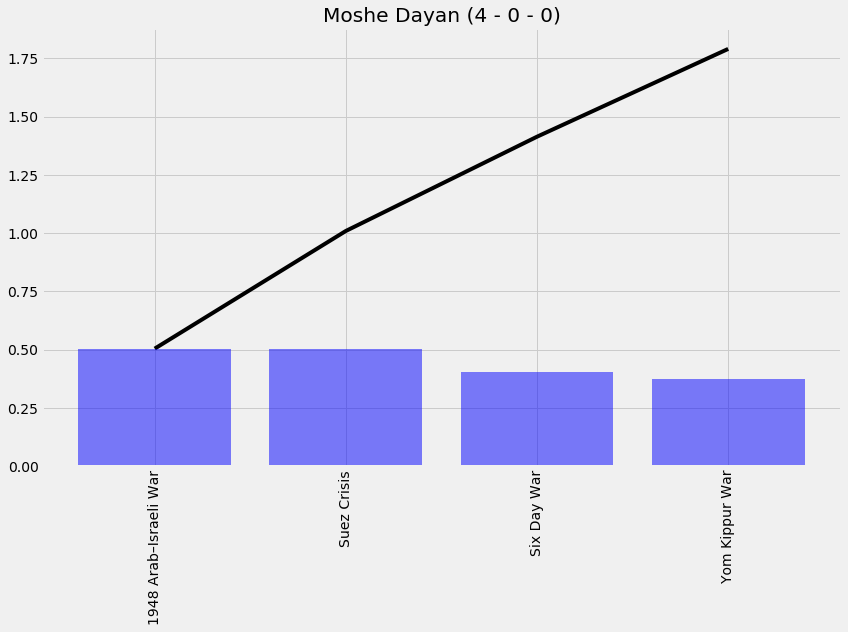

In [135]:
battle_list = []
graph('Moshe Dayan')

In [ ]:
df_battles

In [ ]:
df_model[df_model.Battle == 'Battle_of_Borodino'].transpose()

In [150]:
df_model[df_model.Battle == 'Six Day War']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,...,Artillery_y,Ships_y,Airforce_y,Special_y,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff


In [ ]:
df_battles

In [ ]:
df_war = pd.DataFrame(war_list).sort_values('WAR', ascending = False).reset_index(drop = True)

In [ ]:
df_war.head()

In [ ]:
df_totalwar = df_totalwar = df_totalwar[df_totalwar.General != 'Capital punishment']
df_totalwar = df_totalwar[df_totalwar.General != 'Lieutenant general']

In [ ]:
df_totalwar[df_totalwar.General == 'Erwin Rommel']

In [136]:
import seaborn as sns

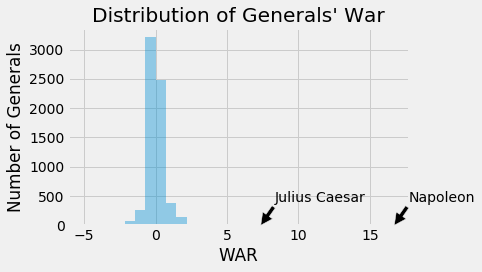

In [137]:
sns.distplot(df_totalwar['WAR'], kde = False, bins = 30)
plt.title("Distribution of Generals' War")
plt.ylabel('Number of Generals')
plt.annotate('Napoleon', xy = (16.713, 1), xytext = (17.713, 400), arrowprops = dict(facecolor = 'black'))
plt.annotate('Julius Caesar', xy = (7.364545, 1), xytext = (8.364545, 400), arrowprops = dict(facecolor = 'black'))
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/distplot.png')

In [ ]:
output_file('google_doc_scatter_hover.html')
source = ColumnDataSource(data = dict(battles = df_totalwar.Battles,
                                      war = df_totalwar.WAR,
                                      general = df_totalwar.General))

hover = HoverTool(tooltips = [('General', '@general'),
                              ('Battles', '@battles'),
                              ('WAR', '@war'),
                                  ])
p = figure(title = 'WAR vs Number of Battles',
           plot_height = 600, 
           plot_width = 800,
          
           tools = [hover, "tap", 'box_zoom'])
p.circle(x = 'war', y = 'battles', size = 10, source = source)
p.xaxis.axis_label = 'WAR'
p.yaxis.axis_label = 'Battles'

url = "http://en.wikipedia.org/wiki/@general"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)
save(p)

In [ ]:
df_battles

In [168]:
def bokeh(commander):
    global df_battles
    battle_list = []
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort_values('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    
    
    source = ColumnDataSource(data = dict(battle = df_battles.Battle,
                              general = df_battles.General,
                              outcome = df_battles.Outcome,
                              value = df_battles.Value,
                              year = df_battles.Year,
                              cumulative = df_battles.cumulative))
    if all(x != -5000 for x in df_battles.Year):
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative'),
                                  ('Year', '@year')])
    else:
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative')
                                  ])
    
    x = list(df_battles.Battle)
    y = list(df_battles.Value)
    y_cum = list(df_battles.cumulative)
    
    output_file('/home/ethanarsht/Downloads/{}_bokeh_warg.html'.format(commander))
    
    p = figure(title = commander + ' ({} - {} - {})'.format(wins, draws, losses), 
               plot_width=800, 
               plot_height=600, 
               x_range = x, 
               tools = [hover])
    
    p.line(x = 'battle', y = 'cumulative', source = source, line_width = 5)
    
    color_mapper = CategoricalColorMapper(factors=['V', 'D', 'I'], palette=['Blue', 'Red', 'Yellow'])
    p.vbar(x = 'battle', 
           top = 'value', 
           source = source, 
           width = 0.9, 
           color={'field': 'outcome', 'transform': color_mapper},
           alpha = 0.5)
    
    p.xaxis.major_label_orientation = math.pi/2
#     show(p)
    save(p)

In [140]:
mka = df_run.loc[8965, 'belligerent']

In [141]:
mka

'Mustafa Kemal Atatürk'

In [149]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,1948 Arab–Israeli War,Moshe Dayan,V,0.504716,1948.0,0.504716
1,Suez Crisis,Moshe Dayan,V,0.504716,1956.0,1.009432
2,Six Day War,Moshe Dayan,V,0.404261,1967.0,1.413693
3,Yom Kippur War,Moshe Dayan,V,0.376520,1973.0,1.790213


In [174]:
battle_list = []
bokeh(u'Ariel Sharon')

2.1708169318


/home/ethanarsht/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [ ]:
df_warchart = pd.DataFrame({'Labels': ['Win = 1', 'Replacement-Level Performance = .51', 'WAR From Battle = .49'],
              'Values': [1, .51, .49]})

In [ ]:
df_warchart = df_warchart.sort_values('Values', ascending = True)

In [ ]:
df_warchart

In [ ]:
df_warchart = df_warchart.iloc[::-1]

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart.index, df_warchart.Values, width = 1, color = ['red', 'blue', 'yellow'])
plt.xticks(df_warchart.index + .5, df_warchart.Labels, rotation = 45)
plt.xticks()
plt.title("Bonaparte's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('napoleon_war_sample')

# ax.set_axis_bgcolor('gray')

In [190]:
df_warchart_two = pd.DataFrame({'Labels': ['Win = -1', 'Replacement-Level Performance = .49', 'WAR From Battle = -.51'],
              'Values': [-1, -.49, -.51]})

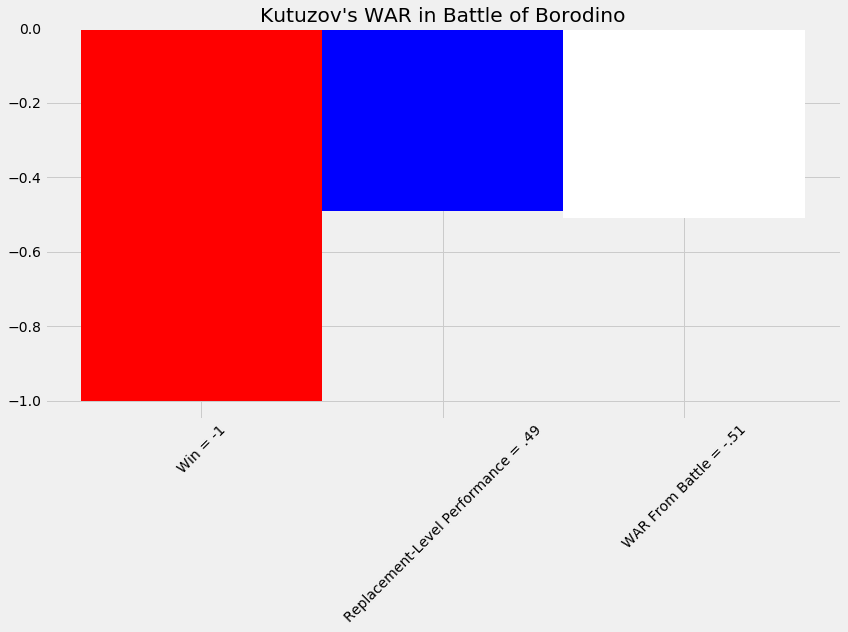

In [195]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart_two.index, df_warchart_two.Values, width = 1, color = ['red', 'blue', 'white'])
plt.xticks(df_warchart_two.index, df_warchart_two.Labels, rotation = 45)
plt.title("Kutuzov's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/kutuzov_war_sample')

# ax.set_axis_bgcolor('gray')

In [ ]:
data = 

In [ ]:
probas = pd.DataFrame(lr.predict_proba(df_x))[1]

In [ ]:
df_y